#### Ioana-Diana Popa

# App4: Sleep Stage Classification Using EEG Signals  

## Project Overview

This project focuses on classifying sleep stages using features extracted from electroencephalography (EEG) signals. The stages include:

- Awake
- REM (Rapid Eye Movement)
- N1, N2 (Light Sleep)
- N3, N4 (Deep Sleep)

I used EEG data recorded from two channels (Fpz-Cz and Pz-Oz) gathered from 12 subjects. Each EEG segment represents 30 seconds of brain activity. The data was split into 9 subjects for training and 3 subjects for testing.

Our goal was to build machine learning models that can automatically classify each segment into the correct sleep stage.

## The main steps of this notebook include:
- Loading and visualizing EEG data  
- Preprocessing the EEG signals from Fpz-Cz and Pz-Oz channels  
- Extracting meaningful time and frequency domain features  
- Standardizing and selecting the most relevant features  
- Training and evaluating two machine learning models:
  - Random Forest Classifier  
  - Gradient Boosting Classifier  
- Comparing their performance using accuracy, precision, recall, F1-score, and confusion matrix

In [52]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
from scipy.stats import skew, kurtosis
from scipy.signal import welch
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

In [3]:
base_data_path = r'D:\Machine Learning Health Technology Project - App 4\Data'

train_dir = os.path.join(base_data_path, 'Train')
test_dir = os.path.join(base_data_path, 'Test')
classes = ['Awake', 'REM', 'N1', 'N2', 'N3', 'N4']

def load_eeg_data(base_dir):
    data = []
    labels = []

    for label in classes:
        class_dir = os.path.join(base_dir, label)
        for file in os.listdir(class_dir):
            if file.endswith('.csv'):
                file_path = os.path.join(class_dir, file)
                eeg = pd.read_csv(file_path)
                data.append(eeg)
                labels.append(label)
    return data, labels

train_data, train_labels = load_eeg_data(train_dir)
test_data, test_labels = load_eeg_data(test_dir)

print(f"Loaded {len(train_data)} training samples and {len(test_data)} test samples.")


Loaded 5963 training samples and 1906 test samples.


# EEG Signal Visualization

I randomly select one EEG file from the training dataset to inspect its content. 
Each file contains two channels: "Fpz-Cz" and "Pz-Oz". Below, I display the first few rows of data and plot both EEG channels to visualize the waveform associated with a given sleep stage.

In [4]:
# Random index
idx = random.randint(0, len(train_data)-1)

sample_eeg = train_data[idx]
sample_label = train_labels[idx]

# Display basic info
print(f"Sample index: {idx}")
print(f"Corresponding label: {sample_label}")
print("Shape of EEG data:", sample_eeg.shape)
print("First 5 rows of EEG data:")
print(sample_eeg.head())

Sample index: 658
Corresponding label: Awake
Shape of EEG data: (3000, 2)
First 5 rows of EEG data:
   EEG Fpz-Cz  EEG Pz-Oz
0   20.907692 -21.898901
1    2.723077  -5.332357
2   -0.046154   0.155311
3   -4.015385 -18.378510
4  -13.523077  -0.776557


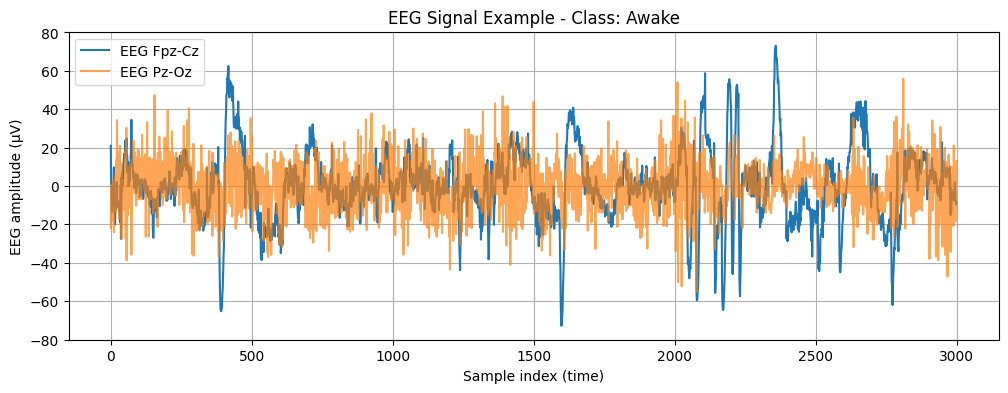

In [5]:
def plot_eeg_sample(eeg_df, label):
    plt.figure(figsize=(12, 4))
    plt.plot(eeg_df['EEG Fpz-Cz'], label='EEG Fpz-Cz')
    plt.plot(eeg_df['EEG Pz-Oz'], label='EEG Pz-Oz', alpha=0.7)
    plt.title(f"EEG Signal Example - Class: {label}")
    plt.xlabel("Sample index (time)")
    plt.ylabel("EEG amplitude (μV)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the selected EEG sample 
plot_eeg_sample(sample_eeg, sample_label)

## EEG Signal Pre-processing: Bandpass Filtering

In this section, I apply **pre-processing** techniques to clean the EEG signals before extracting features.

### Objective:
EEG signals often contain unwanted noise or irrelevant frequency components. To enhance signal quality and focus on the most informative EEG rhythms (Delta, Theta, Alpha, Beta), I apply a **bandpass filter**.

### Why Bandpass Filter?
Different sleep stages are associated with different frequency bands:
- **Delta (0.5–4 Hz)** – Deep sleep (N3, N4)
- **Theta (4–8 Hz)** – Beginning stages of sleep (N1, N2)
- **Alpha (8–13 Hz)** – Principal resting rhythm of the brain
- **Beta (>13 Hz)** – Tense and anxious subjects

To isolate these brainwave frequencies and remove low-frequency drift and high-frequency noise, I use a **Butterworth bandpass filter** with a passband of **0.5 to 40 Hz**.

In [6]:
# Bandpass Filter Function
def bandpass_filter(data, lowcut=0.5, highcut=40.0, fs=100.0, order=5):
    nyq = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq 
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

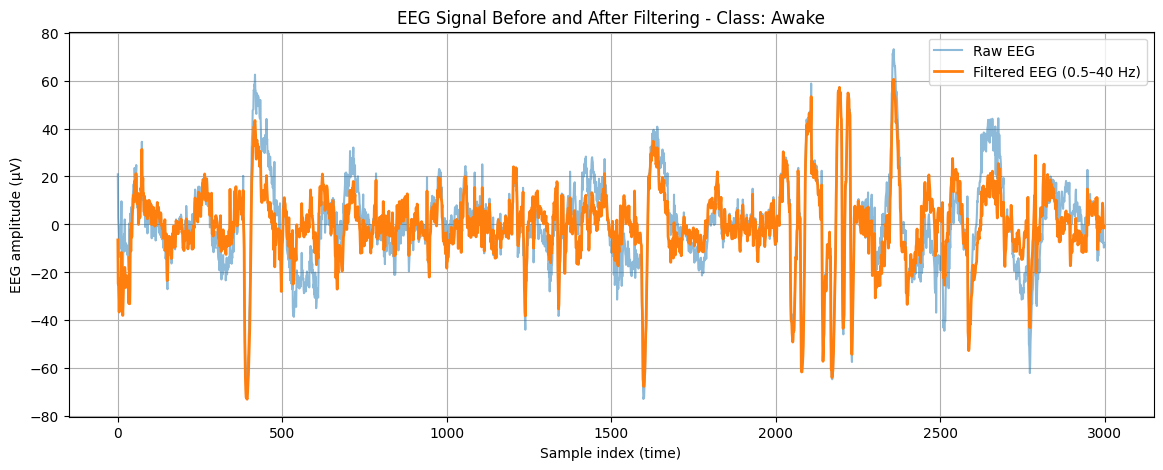

In [7]:
# Get sample EEG signal
raw_fpz_cz = sample_eeg['EEG Fpz-Cz'].values
filtered_fpz_cz = bandpass_filter(raw_fpz_cz)

# Plot raw vs filtered EEG
plt.figure(figsize=(14, 5))
plt.plot(raw_fpz_cz, label='Raw EEG', alpha=0.5)
plt.plot(filtered_fpz_cz, label='Filtered EEG (0.5–40 Hz)', linewidth=2)
plt.title(f"EEG Signal Before and After Filtering - Class: {sample_label}")
plt.xlabel("Sample index (time)")
plt.ylabel("EEG amplitude (µV)")
plt.legend()
plt.grid(True)
plt.show()

## Feature Extraction (Time-domain, Frequency-domain, and Resonance Frequency)

To enable machine learning models to classify EEG segments into sleep stages, I extract meaningful features from each 30-second EEG segment. These features are derived from:

### Time-domain Features:
- `mean`: Average amplitude
- `std`: Standard deviation
- `skew`: Asymmetry of the signal distribution
- `kurtosis`: Sharpness 
- `ptp`: Peak-to-peak range (max - min)
- `zcr`: Zero-crossing rate — how often the signal crosses zero

### Frequency-domain Features (using Welch's method):
- `delta (0.5–4 Hz)`: Deep sleep range
- `theta (4–8 Hz)`: Light sleep / drowsiness
- `alpha (8–13 Hz)`: Relaxed wakefulness
- `beta (13–30 Hz)`: Alert, active thinking
- I calculate both absolute and relative power for each band.

### Resonance Frequency:
- The **resonance frequency** is the frequency at which the power spectrum reaches its **maximum**.
- It may reflect the dominant oscillatory behavior of the brain during a specific sleep stage.

I extract these features for both EEG channels: `Fpz-Cz` and `Pz-Oz`, resulting in a comprehensive 30-feature set.

In [8]:
def extract_features_with_resonance(data_list):
    features = []
    for signal in data_list:
        # Get raw EEG signals for both channels
        fpz = signal['EEG Fpz-Cz'].values
        pz = signal['EEG Pz-Oz'].values

        # Filter the EEG signals
        fpz_f = bandpass_filter(fpz)
        pz_f = bandpass_filter(pz)

        # Time-domain features
        def time_features(sig):
            return {
                'mean': np.mean(sig),
                'std': np.std(sig),
                'skew': skew(sig),
                'kurtosis': kurtosis(sig),
                'ptp': np.ptp(sig),
                'zcr': ((sig[:-1] * sig[1:]) < 0).sum()
            }

        # Frequency-domain power bands & resonance frequency
        def freq_features(sig):
            f, psd = welch(sig, fs=100, nperseg=256)
            total_power = np.sum(psd)
            def band_power(low, high):
                idx = np.logical_and(f >= low, f <= high)
                return np.sum(psd[idx]), np.sum(psd[idx]) / total_power

            delta, delta_rel = band_power(0.5, 4)
            theta, theta_rel = band_power(4, 8)
            alpha, alpha_rel = band_power(8, 13)
            beta, beta_rel = band_power(13, 30)

            # Resonance frequency = frequency with maximum power
            resonance_freq = f[np.argmax(psd)]

            return {
                'delta_power': delta,
                'delta_rel_power': delta_rel,
                'theta_power': theta,
                'theta_rel_power': theta_rel,
                'alpha_power': alpha,
                'alpha_rel_power': alpha_rel,
                'beta_power': beta,
                'beta_rel_power': beta_rel,
                'resonance_freq': resonance_freq
            }

        # Combine all features for both channels
        fpz_feat = time_features(fpz_f)
        fpz_feat.update(freq_features(fpz_f))
        pz_feat = time_features(pz_f)
        pz_feat.update(freq_features(pz_f))

        # Rename keys for uniqueness
        fpz_feat = {f'fpz_{k}': v for k, v in fpz_feat.items()}
        pz_feat = {f'pz_{k}': v for k, v in pz_feat.items()}

        all_feat = {**fpz_feat, **pz_feat}
        features.append(all_feat)

    return pd.DataFrame(features)

# Apply to train and test
X_train = extract_features_with_resonance(train_data)
X_test = extract_features_with_resonance(test_data)

print("Feature matrix shape (train):", X_train.shape)
print("Feature matrix shape (test):", X_test.shape)
print("Example features with resonance frequency:")
display(X_train.head())

Feature matrix shape (train): (5963, 30)
Feature matrix shape (test): (1906, 30)
Example features with resonance frequency:


,fpz_mean,fpz_std,fpz_skew,fpz_kurtosis,fpz_ptp,fpz_zcr,fpz_delta_power,fpz_delta_rel_power,fpz_theta_power,fpz_theta_rel_power,...,pz_zcr,pz_delta_power,pz_delta_rel_power,pz_theta_power,pz_theta_rel_power,pz_alpha_power,pz_alpha_rel_power,pz_beta_power,pz_beta_rel_power,pz_resonance_freq
0,-0.029211,24.879194,-0.508994,1.533710,171.270933,320,1090.755046,0.648641,225.462716,0.134076,...,510,41.542493,0.482460,12.486377,0.145013,9.504928,0.110387,7.344275,0.085294,0.781250
1,0.031255,19.968951,-0.542972,3.488893,178.907102,553,780.399596,0.693996,107.788904,0.095855,...,753,48.232978,0.340223,14.129149,0.099663,18.269867,0.128871,38.553726,0.271948,1.171875
2,0.000634,23.820395,-0.746859,1.876921,160.528341,307,975.715298,0.655375,88.927296,0.059731,...,788,44.859058,0.415655,9.868958,0.091444,14.503003,0.134382,20.958115,0.194194,1.171875
3,0.006445,26.865664,-0.586083,2.282378,207.666036,302,1537.413718,0.815380,118.571658,0.062885,...,656,52.230968,0.416252,15.973443,0.127300,15.664793,0.124840,24.739539,0.197161,1.171875
4,-0.017196,21.719794,-1.217761,2.856995,144.450204,338,881.298206,0.775443,160.379178,0.141116,...,564,38.318082,0.500877,11.349259,0.148353,10.926359,0.142825,9.807942,0.128205,1.171875


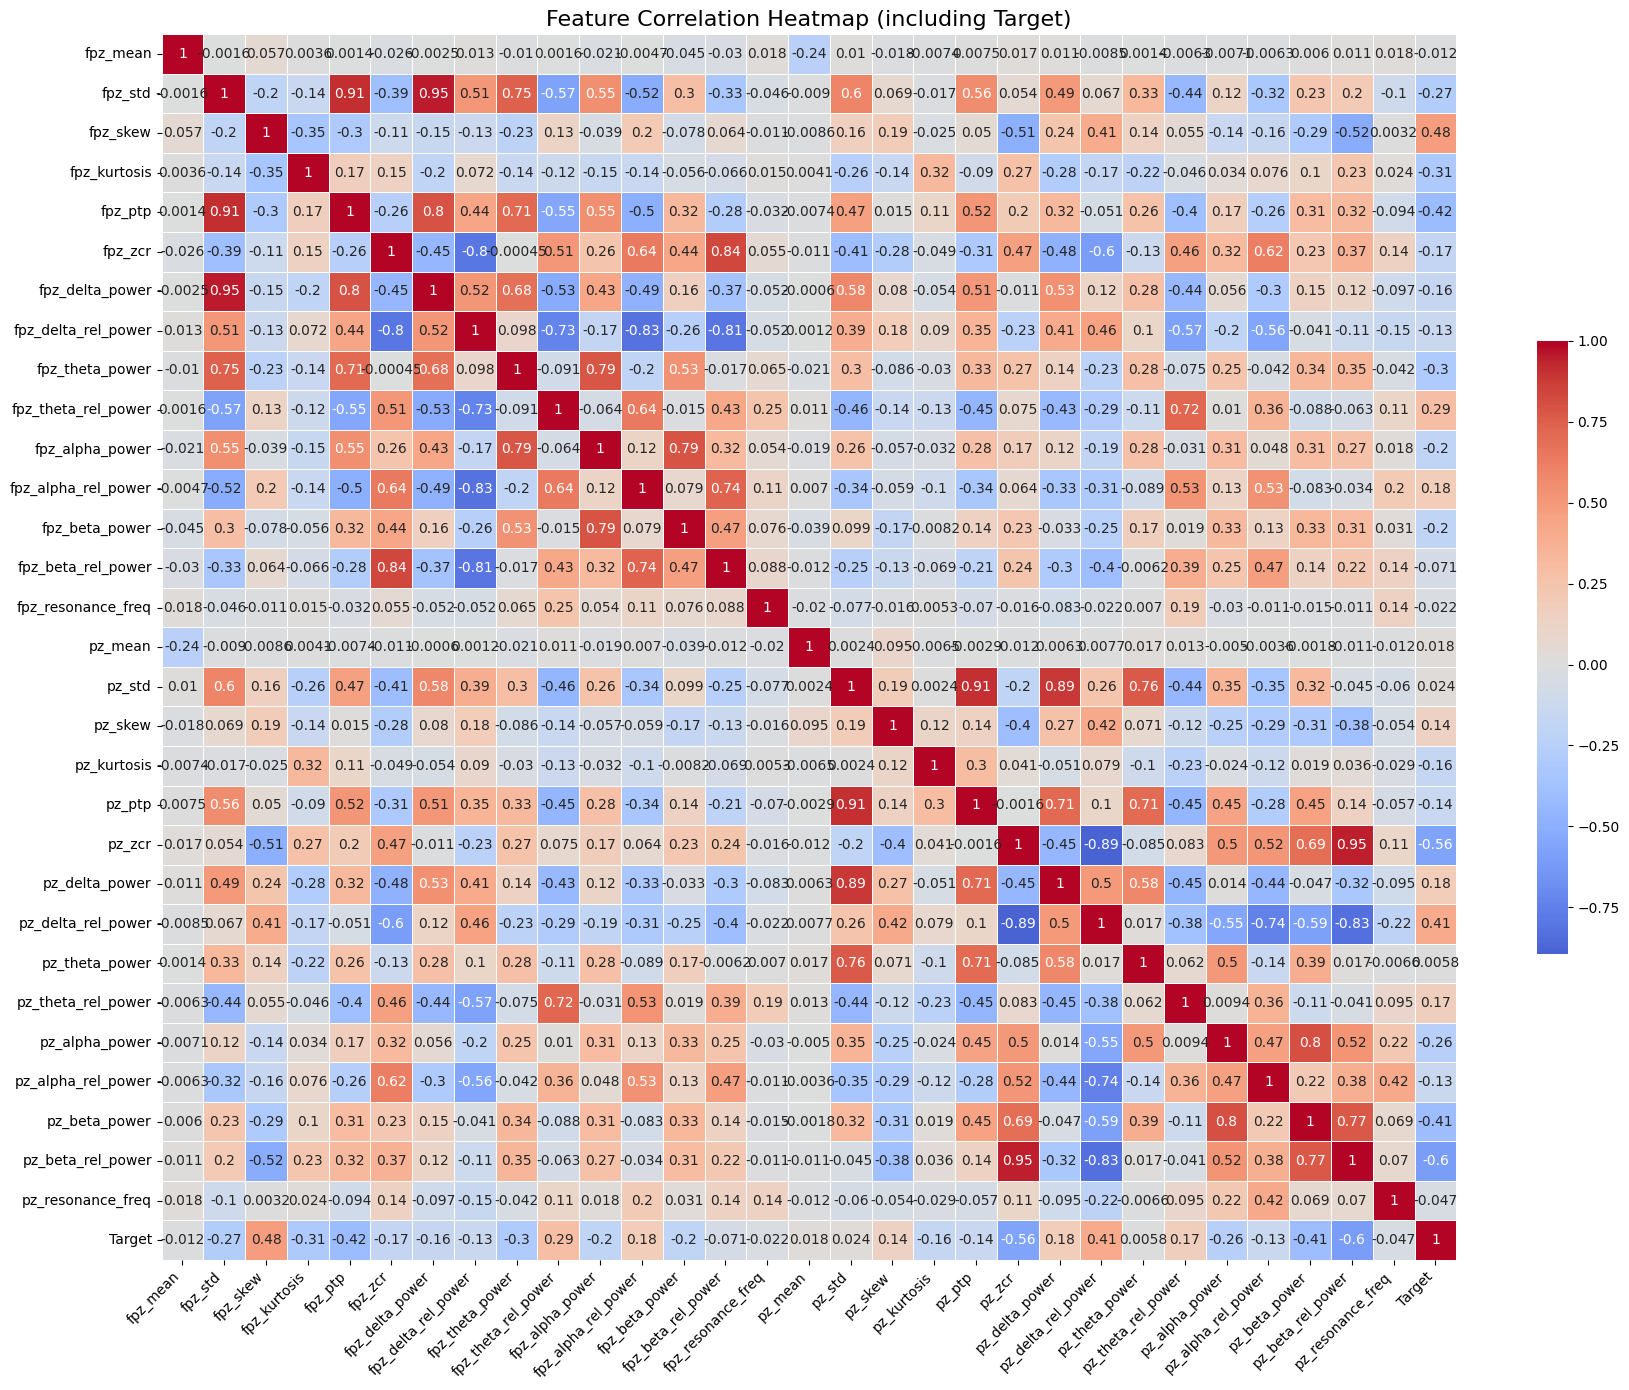

In [31]:
# Encode labels numerically just for correlation computation
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Combine features and target into one DataFrame
correlation_df = X_train.copy()
correlation_df['Target'] = train_labels_encoded

# Compute correlation matrix
corr_matrix = correlation_df.corr()

# Plot heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            linewidths=0.5, cbar_kws={"shrink": 0.5})
plt.title("Feature Correlation Heatmap (including Target)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [53]:
# Compute correlation matrix
corr_matrix = X_train.corr().abs()

# Create a mask to ignore self-correlation
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find feature pairs with correlation > 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print("Highly correlated features (corr > 0.9):")
print(to_drop)

# Drop them from train and test sets
X_train_filtered = X_train.drop(columns=to_drop)
X_test_filtered = X_test.drop(columns=to_drop)

Highly correlated features (corr > 0.9):
['fpz_ptp', 'fpz_delta_power', 'pz_ptp', 'pz_beta_rel_power']


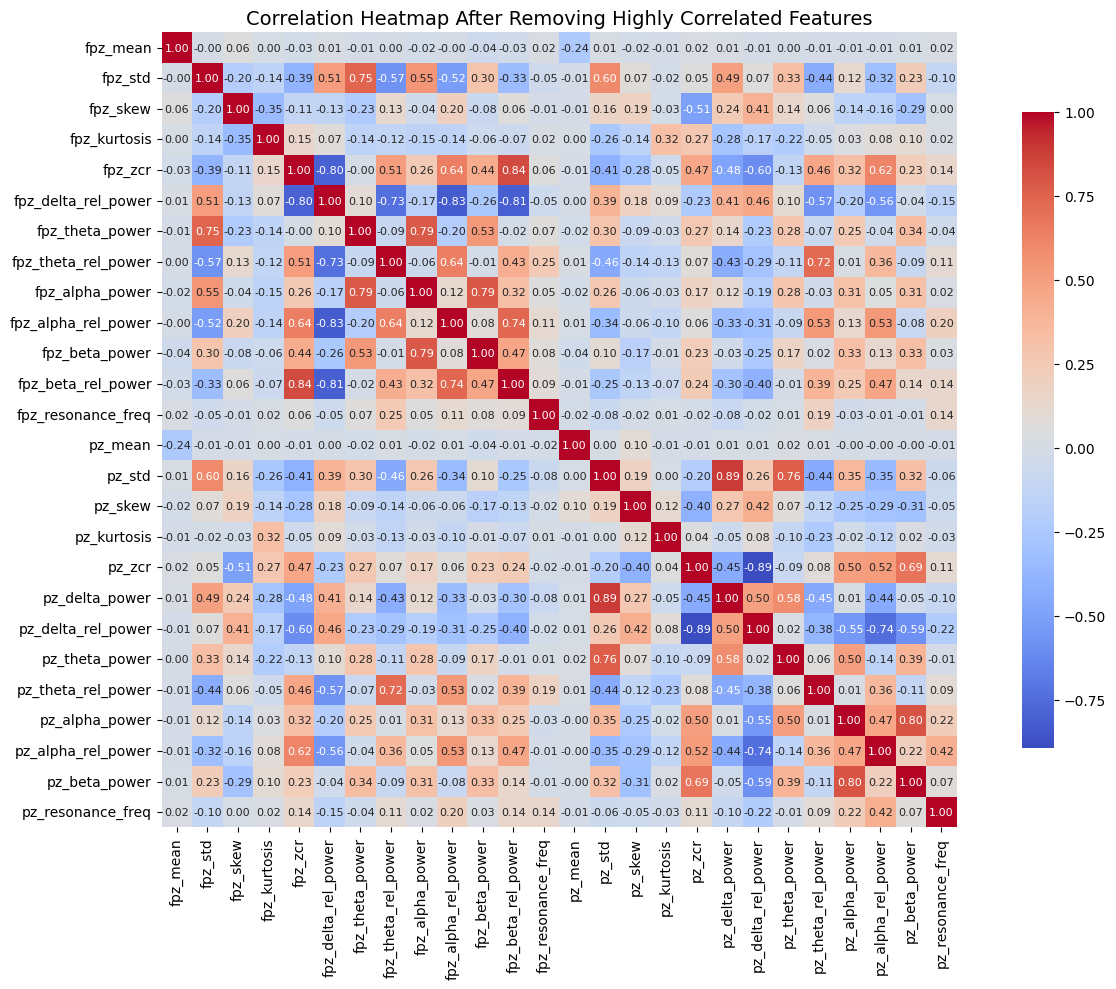

In [33]:
# Compute new correlation matrix after dropping highly correlated features
filtered_corr_matrix = X_train_filtered.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    filtered_corr_matrix,
    annot=True, fmt=".2f",
    cmap='coolwarm',
    square=True,
    cbar_kws={'shrink': .8},
    annot_kws={"size": 8}
)
plt.title("Correlation Heatmap After Removing Highly Correlated Features", fontsize=14)
plt.tight_layout()
plt.show()

I started with 30 features extracted from EEG signals. Since some of them were very similar (highly correlated), I used a correlation matrix to detect redundancy. Features with correlation above 0.9 were considered too similar, which can hurt model performance by introducing noise and overfitting. So I removed only one from each highly correlated pair to reduce redundancy while preserving useful information. After that, I visualized the cleaned dataset using a new heatmap. This improves interpretability and sets a stronger foundation for training robust ML models.

## Standardizing the Feature Data

Standardization is a crucial preprocessing step where each feature is transformed to have a mean of 0 and a standard deviation of 1.

### Visualizing Standardized Features

After applying standardization, it's important to visually inspect the feature distributions.
Below, I plot histograms of a few selected standardized features from the training set.

In [34]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

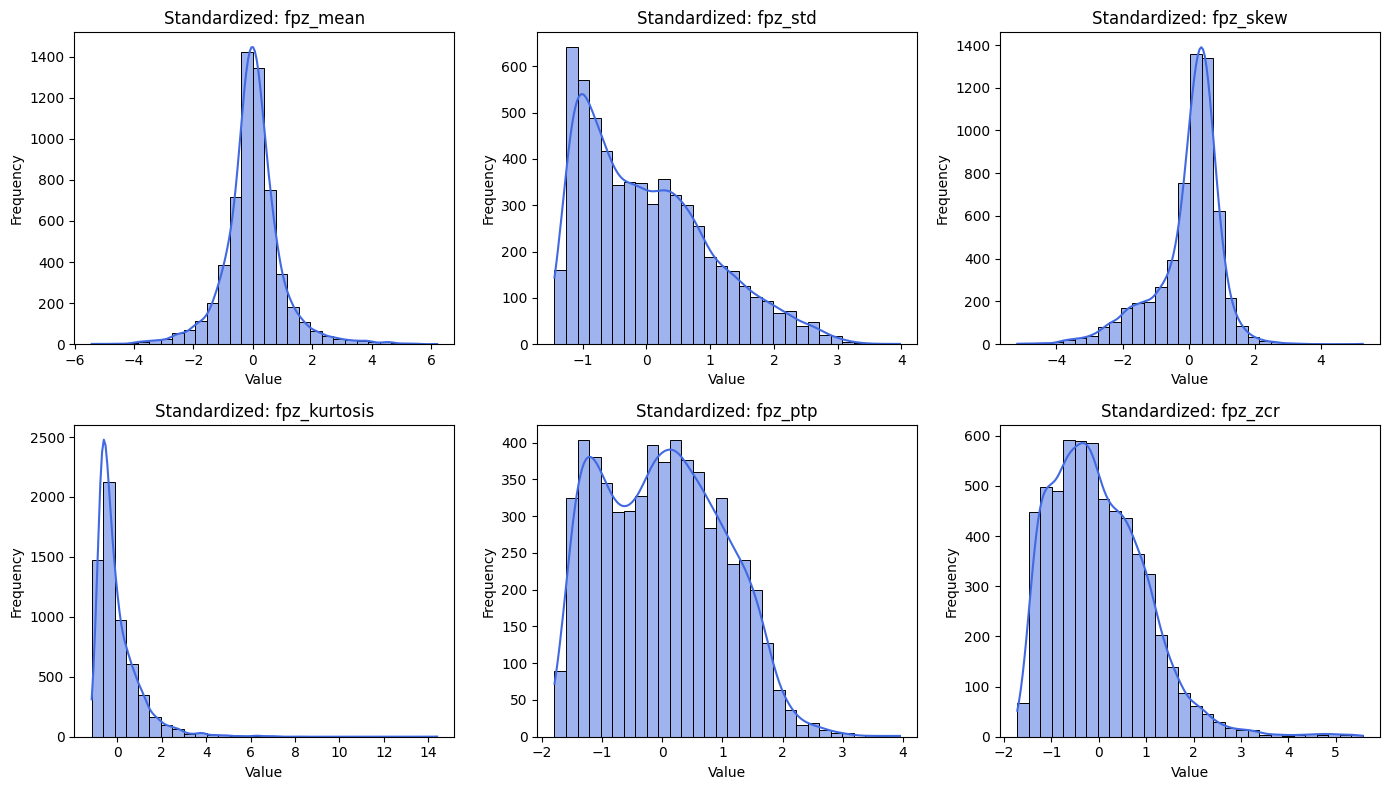

In [35]:
# Convert the scaled data back into a DataFrame for easier plotting
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Plot distributions of the first 6 standardized features
plt.figure(figsize=(14, 8))
for i, col in enumerate(X_train_scaled_df.columns[:6]):
    plt.subplot(2, 3, i + 1)
    sns.histplot(X_train_scaled_df[col], kde=True, color='royalblue', bins=30)
    plt.title(f"Standardized: {col}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ✨Train Supervised Classifiers✨
## Classifier 1: Random Forest

For this project, I begin with the **Random Forest Classifier**, a robust and widely used ensemble machine learning method.

I chose Random Forest because:
- It combines multiple decision trees to make more accurate and stable predictions.
- EEG features can be complex and non-linear.
- It works well with tabular data like our extracted features.
- It provides feature importance, which helps interpret which EEG features are most influential for sleep stage classification.

I will train the classifier on the **standardized training set** and evaluate it on the **test set** using:
- Accuracy score
- Classification report (precision, recall, F1-score)
- Confusion matrix

Random Forest Classification Report:

              precision    recall  f1-score   support

       Awake       0.98      0.99      0.99       450
          N1       0.64      0.56      0.60       295
          N2       0.80      0.89      0.84       450
          N3       0.88      0.75      0.81       310
          N4       0.57      0.36      0.44        33
         REM       0.69      0.75      0.72       368

    accuracy                           0.80      1906
   macro avg       0.76      0.72      0.73      1906
weighted avg       0.80      0.80      0.80      1906



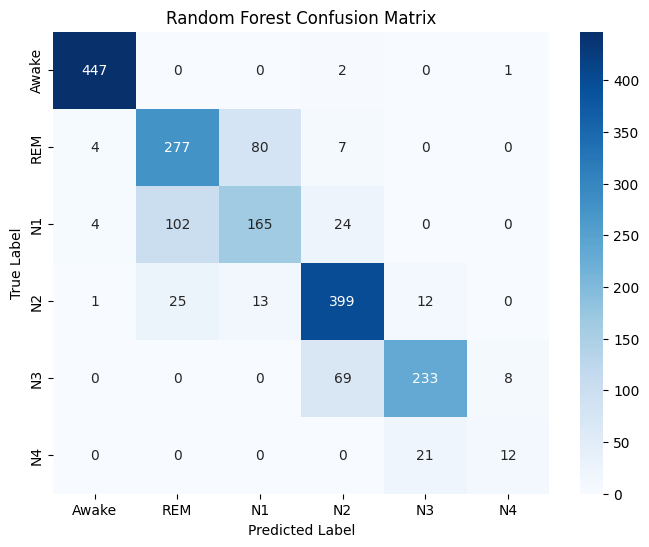

In [38]:
# Set the target labels
y_train = train_labels
y_test = test_labels

# Train Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=2004)
rf_clf.fit(X_train_scaled, y_train)

# Predict
y_pred_rf = rf_clf.predict(X_test_scaled)

# Evaluate
print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_rf, labels=classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest Confusion Matrix")
plt.show()

The Random Forest model reached an overall accuracy of 80%, showing it performs well on most sleep stages. This strong performance is largely influenced by how many examples each stage has in the training and test datasets. For instance, the 'Awake' and 'N2' stages had the most samples, which helped the model learn their patterns effectively, reflected in their high F1-scores of 0.99 and 0.84, respectively.

Stages like 'REM' and 'N3', which had a moderate number of samples, also performed reasonably well. However, the model struggled with 'N1' and especially 'N4', both of which had fewer training and test examples. 'N4' in particular had only 33 test samples, which made it difficult for the model to recognize, resulting in a low F1-score of 0.44.

This clearly shows that when the model sees fewer examples of a class, it has a harder time learning and predicting it accurately. 

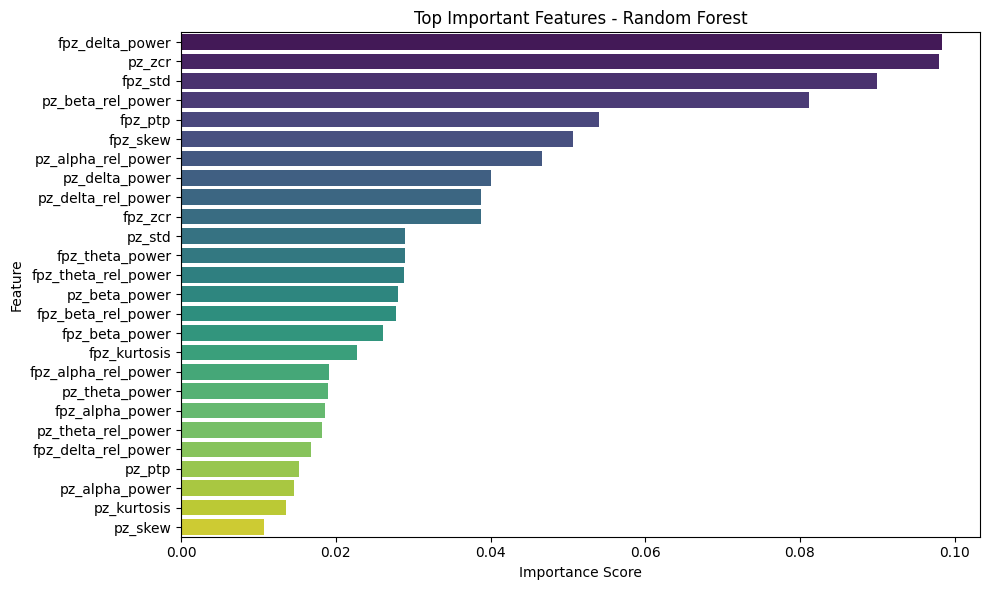

,Feature,Importance
6,fpz_delta_power,0.098374
20,pz_zcr,0.097934
1,fpz_std,0.089944
28,pz_beta_rel_power,0.081182
4,fpz_ptp,0.054082
2,fpz_skew,0.050612
26,pz_alpha_rel_power,0.046697
21,pz_delta_power,0.040017
22,pz_delta_rel_power,0.038830
5,fpz_zcr,0.038790


In [45]:
# Get feature importances
importances = rf_clf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easier visualization
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top most important features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(26), palette='viridis')
plt.title("Top Important Features - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
display(feat_imp_df)

Features with very low importance (less than 0.01) are considered to have minimal contribution to the classification task. To simplify the model and potentially improve generalization, I removed these low-importance features from the dataset.

This step helps:
- Reduce noise in the data
- Lower the risk of overfitting
- Improve model interpretability

The model was then retrained using only the most relevant features. After retraining, I compared the classification metrics to evaluate whether this feature selection improved or maintained the model's accuracy and robustness.

In [56]:
threshold = 0.01
low_importance_features = feat_imp_df[feat_imp_df['Importance'] < threshold]['Feature']

# Drop those low importance features from both training and test sets
X_train_filtered_final = X_train_filtered.drop(columns=low_importance_features)
X_test_filtered_final = X_test_filtered.drop(columns=low_importance_features)

print(f"Remaining features after removal: {X_train_filtered_final.columns}")

Remaining features after removal: Index(['fpz_std', 'fpz_skew', 'fpz_kurtosis', 'fpz_zcr', 'fpz_delta_rel_power',
       'fpz_theta_power', 'fpz_theta_rel_power', 'fpz_alpha_power',
       'fpz_alpha_rel_power', 'fpz_beta_power', 'fpz_beta_rel_power', 'pz_std',
       'pz_skew', 'pz_kurtosis', 'pz_zcr', 'pz_delta_power',
       'pz_delta_rel_power', 'pz_theta_power', 'pz_theta_rel_power',
       'pz_alpha_power', 'pz_alpha_rel_power', 'pz_beta_power'],
      dtype='object')


Random Forest Classification Report (After Feature Selection):

              precision    recall  f1-score   support

       Awake       0.98      0.99      0.98       450
          N1       0.62      0.59      0.60       295
          N2       0.77      0.84      0.81       450
          N3       0.86      0.75      0.80       310
          N4       0.55      0.36      0.44        33
         REM       0.69      0.72      0.70       368

    accuracy                           0.79      1906
   macro avg       0.74      0.71      0.72      1906
weighted avg       0.79      0.79      0.79      1906



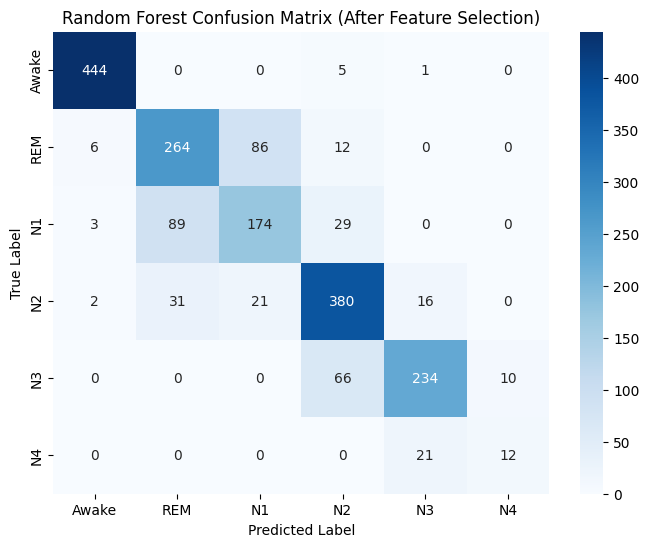

In [48]:
# Train Random Forest on filtered features
rf_clf_filtered = RandomForestClassifier(n_estimators=100, random_state=2004)
rf_clf_filtered.fit(X_train_filtered_final_scaled, y_train)

# Predict with the new model
y_pred_rf_filtered = rf_clf_filtered.predict(X_test_filtered_final_scaled)

# Evaluate the new model
print("Random Forest Classification Report (After Feature Selection):\n")
print(classification_report(y_test, y_pred_rf_filtered))

# Confusion matrix for the new model
conf_mat_filtered = confusion_matrix(y_test, y_pred_rf_filtered, labels=classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_filtered, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Random Forest Confusion Matrix (After Feature Selection)")
plt.show()

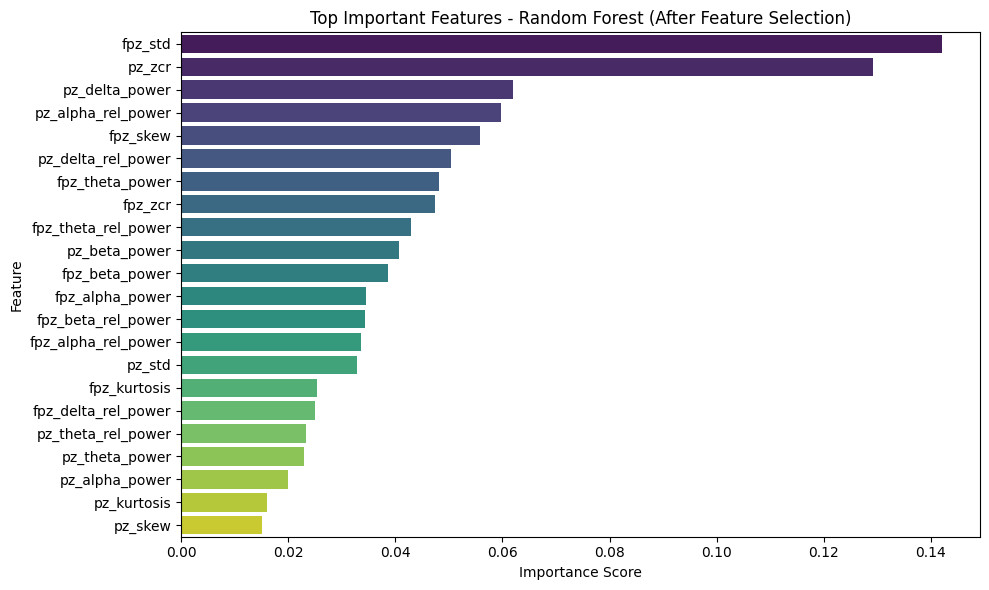

,Feature,Importance
0,fpz_std,0.142086
14,pz_zcr,0.129122
15,pz_delta_power,0.061960
20,pz_alpha_rel_power,0.059752
1,fpz_skew,0.055815
16,pz_delta_rel_power,0.050372
5,fpz_theta_power,0.048094
3,fpz_zcr,0.047319
6,fpz_theta_rel_power,0.042966
21,pz_beta_power,0.040626


In [55]:
# Get feature importances again for the filtered model (to verify importance on reduced features)
importances_filtered = rf_clf_filtered.feature_importances_
feature_names_filtered = X_train_filtered_final.columns

# Create a DataFrame for easier visualization of feature importance in the filtered model
feat_imp_df_filtered = pd.DataFrame({
    'Feature': feature_names_filtered,
    'Importance': importances_filtered
}).sort_values(by='Importance', ascending=False)

# Display top important features from the filtered dataset
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df_filtered.head(22), palette='viridis')
plt.title("Top Important Features - Random Forest (After Feature Selection)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

display(feat_imp_df_filtered)

- Initial Model (before feature selection): Accuracy of 80%
- Updated Model (after feature selection): Accuracy of 79%

The accuracy of the model has slightly decreased by 1% after feature selection, but it's important to note that a 1% drop in accuracy is minimal and might be a good trade-off for reducing feature complexity and improving model interpretability.

## Classifier 2: Gradient Boosting
### Why Gradient Boosting?

- It builds trees **sequentially**, learning from the mistakes of the previous trees, helping the model improve gradually.
- It tends to perform **very well with structured/tabular data**, like the EEG-derived features.
- It can offer **better generalization** and focus on difficult-to-classify instances (e.g., underrepresented sleep stages like N1 or N4).
- It allows for **fine control** via hyperparameters like learning rate, number of estimators, and tree depth.

By applying Gradient Boosting after our thoughtful feature selection process (eliminating highly correlated and low-importance features), I was aiming to see if this model can capture complex patterns in the data more effectively than Random Forest.

Gradient Boosting Classification Report:

              precision    recall  f1-score   support

       Awake       0.98      0.97      0.97       450
          N1       0.61      0.57      0.59       295
          N2       0.78      0.86      0.82       450
          N3       0.87      0.80      0.84       310
          N4       0.73      0.33      0.46        33
         REM       0.69      0.72      0.70       368

    accuracy                           0.80      1906
   macro avg       0.78      0.71      0.73      1906
weighted avg       0.80      0.80      0.79      1906



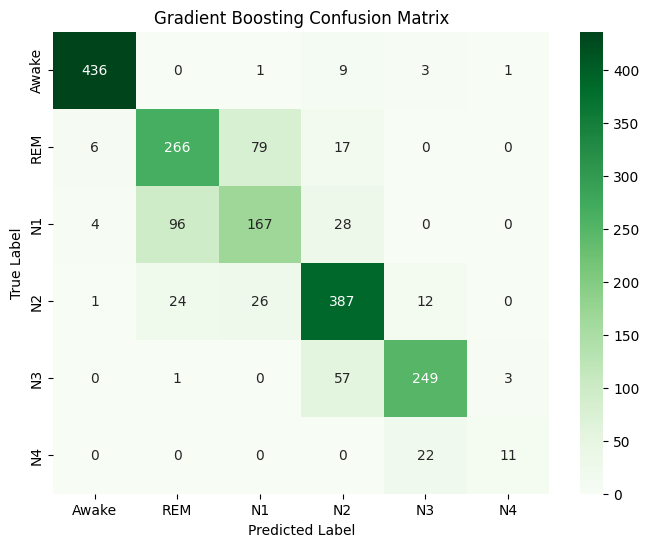

In [50]:
# Initialize the model
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=2004)

# Train the model
gb_clf.fit(X_train_filtered_final_scaled, y_train)

# Predict
y_pred_gb = gb_clf.predict(X_test_filtered_final_scaled)

# Evaluate
print("Gradient Boosting Classification Report:\n")
print(classification_report(y_test, y_pred_gb))

# Confusion Matrix
conf_mat_gb = confusion_matrix(y_test, y_pred_gb, labels=classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_gb, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

The Gradient Boosting model reached 80% accuracy, showing solid performance overall.

- It handled complex sleep stages like N3 and N4 slightly better than Random Forest.
- N2 and REM remained consistently well classified.
- N1 was still difficult, but results were comparable to RF.

Overall, Gradient Boosting showed itself to be a strong model, especially useful for capturing subtle patterns and improving predictions on harder-to-classify stages.

## Random Forest vs. Gradient Boosting

| Sleep Stage | Random Forest F1 | Gradient Boosting F1 | Which Did Better?            |
|-------------|------------------|-----------------------|-------------------------------|
| **Awake**   | 0.98             | 0.97                  | Random Forest (but very close)|
| **N1**      | 0.60             | 0.59                  | Random Forest(very close)     |
| **N2**      | 0.81             | 0.82                  | Gradient Boosting (very close)|
| **N3**      | 0.80             | 0.84                  | Gradient Boosting             |
| **N4**      | 0.44             | 0.46                  | Gradient Boosting             |
| **REM**     | 0.70             | 0.70                  | Both models performed equally well|

### Overall Accuracy

- **Random Forest**: 79%  
- **Gradient Boosting**: 80%

Both models did a great job, but Gradient Boosting had a slight edge overall, especially in detecting the deeper sleep stages like N3 and N4. These are often trickier to classify, so that little improvement can be meaningful. Random Forest was a bit better at recognizing when someone was **awake**, and it’s generally faster and simpler to run.